# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
#list(df_new['Target'])

In [11]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [12]:
targets = list(set(df_new['Target']))
targets

['3.6',
 '6.2',
 '7.2',
 '10.c',
 '3.1',
 '8.2',
 '17.8',
 '9.2',
 '9.c',
 '9.4',
 '15.4',
 '16.a',
 '14.4',
 '7.1',
 '2.1',
 '17.3',
 '15.2',
 '3.9',
 '15.1',
 '3.4',
 '17.19',
 '4.2',
 '17.2',
 '6.1',
 '14.5',
 '8.4',
 '3.3',
 '12.2',
 '1.1',
 '6.b',
 '9.5',
 '16.3',
 '8.1']

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [13]:
# create empty dictionary
target_dfs = {}

In [14]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [15]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [16]:
# find row with maximum amount of data points for each target
max_dfrows = {}

In [17]:
for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [18]:
max_dfrows

{'1.1':   Unnamed: 0    Category                              Indicator Description  \
 0        106  Population  Proportion of population below the internation...   
 
   Goal Target Indicator Ref     Unit Unit multiplier 1984 1985  \
 0    1    1.1         1.1.1  Percent           Units  NaN  NaN   
 
          ...        2009 2010 2011 2012  2013 2014 2015 2016 2017  \
 0        ...         NaN  NaN  NaN  NaN  10.7  NaN  NaN  NaN  NaN   
 
   Years with values  
 0                 2  
 
 [1 rows x 43 columns], '10.c':      Unnamed: 0       Category  \
 117          13  E&P (Percent)   
 
                                  Indicator Description  Goal Target  \
 117  Remittance costs as a proportion of the amount...    10   10.c   
 
     Indicator Ref     Unit Unit multiplier  1984  1985        ...          \
 117        10.c.1  Percent           Units   NaN   NaN        ...           
 
      2009  2010  2011  2012  2013  2014  2015  2016  2017  Years with values  
 117   NaN   NaN  

In [19]:
frames = list(max_dfrows[target] for target in targets)
frames

[    Unnamed: 0    Category                    Indicator Description  Goal  \
 65         123  Population  Death rate due to road traffic injuries     3   
 
    Target Indicator Ref     Unit Unit multiplier  1984  1985  \
 65    3.6         3.6.1  Percent           Units   NaN   NaN   
 
           ...          2009  2010  2011  2012  2013  2014  2015  2016  2017  \
 65        ...           NaN   1.8   NaN   NaN  1.74   NaN   NaN   NaN   NaN   
 
     Years with values  
 65                  4  
 
 [1 rows x 43 columns],
    Unnamed: 0    Category                              Indicator Description  \
 13        133  Population  Proportion of population using safely managed ...   
 
    Goal Target Indicator Ref     Unit Unit multiplier 1984 1985  \
 13    6    6.2         6.2.1  Percent           Units  NaN  NaN   
 
           ...          2009   2010   2011   2012   2013   2014   2015 2016  \
 13        ...         28.29  27.58  26.97  26.23  25.48  24.73  23.97  NaN   
 
    2017 Y

In [20]:
final_df = pd.concat(frames, axis=0)

In [21]:
final_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
65,123,Population,Death rate due to road traffic injuries,3,3.6,3.6.1,Percent,Units,NaN,NaN,...,NaN,1.8,NaN,NaN,1.74,NaN,NaN,NaN,NaN,4
13,133,Population,Proportion of population using safely managed ...,6,6.2,6.2.1,Percent,Units,NaN,NaN,...,28.29,27.58,26.97,26.23,25.48,24.73,23.97,NaN,NaN,16
143,38,Environment (Percent),Renewable energy share in the total final ener...,7,7.2,7.2.1,Percent,Units,NaN,NaN,...,17.71,17.51,17.54,17.91,18.19,18.33,NaN,NaN,NaN,15
117,13,E&P (Percent),Remittance costs as a proportion of the amount...,10,10.c,10.c.1,Percent,Units,NaN,NaN,...,NaN,NaN,8.9,9,8.6,8.2,7.5,NaN,NaN,5
57,114,Population,Maternal mortality ratio,3,3.1,3.1.1,Percent,Units,NaN,NaN,...,NaN,24.6,NaN,NaN,NaN,NaN,21.6,NaN,NaN,4


### clean-up data frames

In [22]:
# Drop unused columns, transpose 
final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [23]:
final_t

Target,3.6,6.2,7.2,10.c,3.1,8.2,17.8,9.2,9.c,9.4,...,6.1,14.5,8.4,3.3,12.2,1.1,6.b,9.5,16.3,8.1
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# shuffle data
final_t_shuffled = final_t.sample(frac=1).reset_index(drop=True)
final_t_shuffled

Target,3.6,6.2,7.2,10.c,3.1,8.2,17.8,9.2,9.c,9.4,...,6.1,14.5,8.4,3.3,12.2,1.1,6.b,9.5,16.3,8.1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,31.58,16.89,NaN,NaN,3.42,14.26,15.26,60.74,2.61102e+10,...,45.69,NaN,8.77,17,8.77,NaN,NaN,87.311,NaN,2.81
2,NaN,28.29,17.71,NaN,NaN,-0.71,25.66,14.99,87.32,2.87486e+10,...,54.02,NaN,9.69,15.9,9.69,NaN,NaN,100.752,NaN,-3.24
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.8,33.76,17.45,NaN,34.1,2.86,6.56,15.15,78.61,2.31445e+10,...,40.95,1.72,8,17.2,8,NaN,NaN,80.637,NaN,3.01
6,NaN,28.98,17.14,NaN,NaN,1.83,23.18,15.74,84.22,2.91648e+10,...,52.49,NaN,9.78,16.1,9.78,NaN,NaN,98.358,NaN,0.2
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21.62,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.74,25.48,18.19,8.6,NaN,1.93,37.18,15.99,95.54,3.21294e+10,...,55.22,NaN,NaN,14.7,NaN,10.7,NaN,108.754,NaN,1.08


### R-squared value of linear regression to detect connections

In [25]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

mask_train = ~np.isnan(targets_X_train) & ~np.isnan(targets_Y_train)
print(mask_train)
targets_X_train = final_t_shuffled[targetx][:-6].reshape(-1, 1)
print(targets_X_train)
print(targets_X_train[mask_train])

In [26]:
# old version for environment
keep =[]
for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            
            # Split the data into training/testing sets
            targets_X_train = final_t_shuffled[targetx][:-6]
            print(type(targets_X_train))
            targets_X_train = targets_X_train.reshape(-1, 1)
            print("Train var", targets_X_train, type(targets_X_train))
            targets_X_valid = final_t_shuffled[targetx][-6:].reshape(-1, 1) 
            print("Validation var", targets_X_valid, type(targets_X_valid))
        
            # Split the data into training/testing sets
            targets_Y_train = final_t_shuffled[targety][:-6].reshape(-1, 1)
            print("Train target", targets_Y_train, type(targets_Y_train))
            targets_Y_valid = final_t_shuffled[targety][-6:].reshape(-1, 1)
            print("Validation target", targets_Y_valid, type(targets_Y_valid))

            # use mask to account for nan values

            mask_train = ~np.isnan(targets_X_train) & ~np.isnan(targets_Y_train)

            targets_X_train = targets_X_train[mask_train]
            targets_Y_train = targets_Y_train[mask_train]


            mask_valid = ~np.isnan(targets_X_valid) & ~np.isnan(targets_Y_valid)

            targets_X_valid = targets_X_valid[mask_valid].reshape(-1, 1)
            targets_Y_valid = targets_Y_valid[mask_valid].reshape(-1, 1)
                                              

            # do not consider NaN pairs

            if (len(targets_X_train) > 1 and len(targets_X_valid) > 1):

                targets_X_train = targets_X_train.reshape(-1, 1)
                targets_Y_train = targets_Y_train.reshape(-1, 1)

                linreg = linear_model.LinearRegression()
                linreg.fit(targets_X_train, targets_Y_train)

                # Make predictions using the testing set
                targets_y_pred = linreg.predict(targets_X_valid)

                #linreg.fit([final_t[targetx]], [final_t[targety]])

                plt.scatter(targets_X_train, targets_Y_train,  color='black')
                plt.plot(targets_X_valid, targets_y_pred, color='blue', linewidth=3)

                plt.xticks(())
                plt.yticks(())
                plt.xlabel(targetx)
                plt.ylabel(targety)
                plt.show()

#print(keep)
        

<class 'pandas.core.series.Series'>
Train var [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]
 [nan]
 [1.7399999999999998]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.88]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] <class 'numpy.ndarray'>
Validation var [[nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]] <class 'numpy.ndarray'>
Train target [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]
 [nan]
 [1.7399999999999998]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [1.88]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] <class 'numpy.ndarray'>
Validation target [[nan]
 [nan]
 [nan]
 [1.8]
 [nan]
 [nan]] <class 'numpy.ndarray'>


/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [75]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return mae, rae, rmse, r2

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


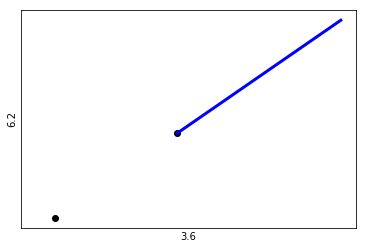

MAE: 10.00500
RMSE: 10.71124
R2: 0.000


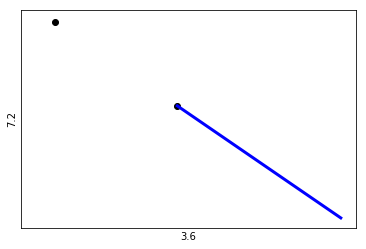

MAE: 0.25333
RMSE: 0.31868
R2: 0.000


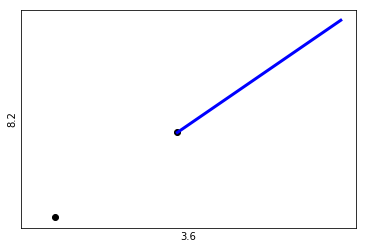

MAE: 1.27000
RMSE: 1.27142
R2: 0.000


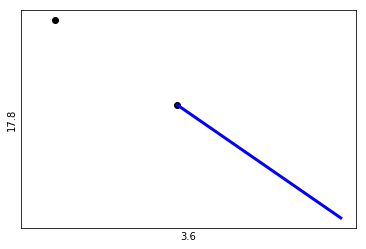

MAE: 36.28833
RMSE: 38.80187
R2: 0.000


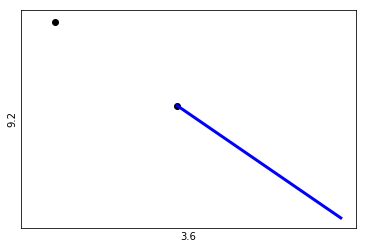

MAE: 0.95500
RMSE: 0.99952
R2: 0.000


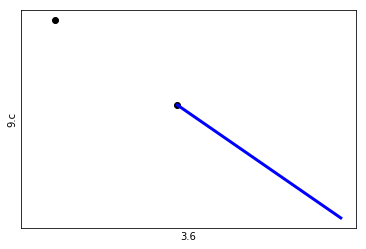

MAE: 8.44667
RMSE: 8.48291
R2: 0.506


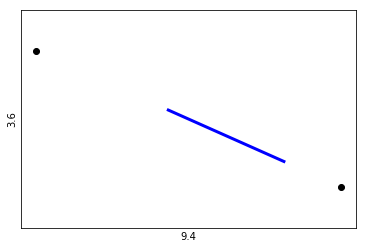

MAE: 0.07739
RMSE: 0.08251
R2: 0.000


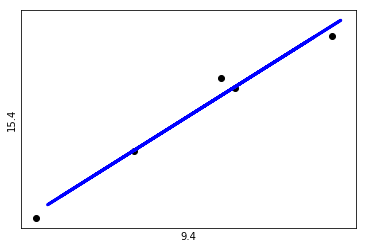

MAE: 0.53756
RMSE: 0.58435
R2: 0.966


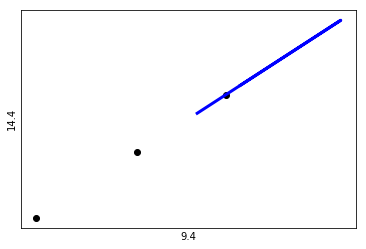

MAE: 4.11740
RMSE: 4.51389
R2: 0.000


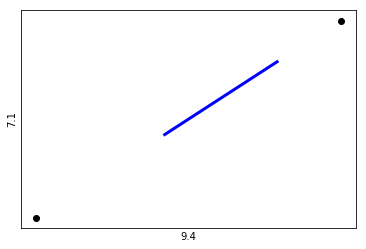

MAE: 1.00072
RMSE: 1.02636
R2: 0.751


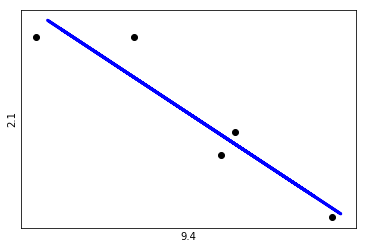

MAE: 0.44744
RMSE: 0.56734
R2: 0.868


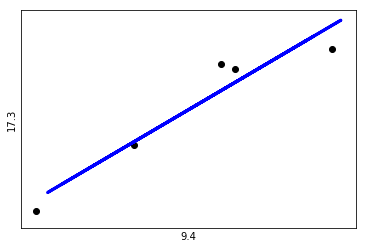

MAE: 0.02352
RMSE: 0.03018
R2: 0.901


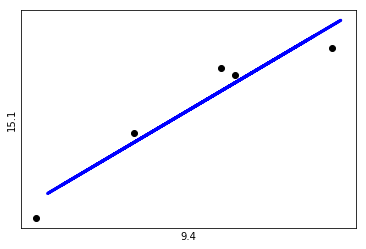

MAE: 0.65768
RMSE: 0.82242
R2: 0.947


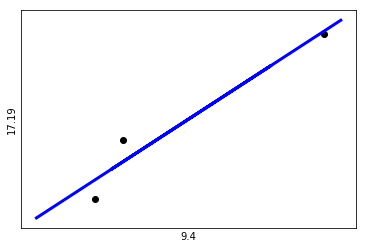

MAE: 98688366.66084
RMSE: 110893018.44064
R2: 0.000


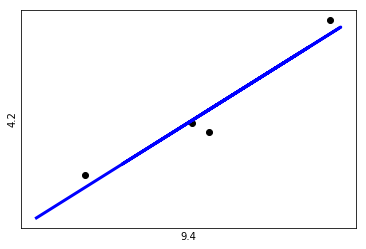

MAE: 1.13974
RMSE: 1.36224
R2: 0.831


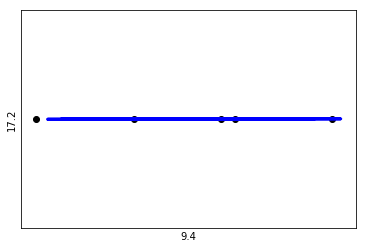

MAE: 0.00001
RMSE: 0.00001
R2: 0.815


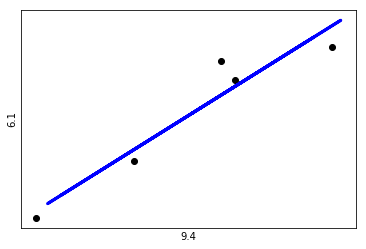

MAE: 0.68318
RMSE: 0.97405
R2: 0.967


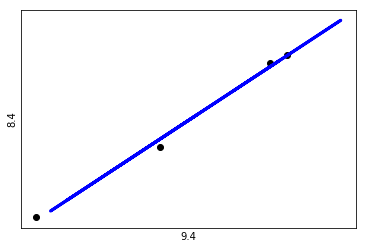

MAE: 0.05534
RMSE: 0.06047
R2: 0.994


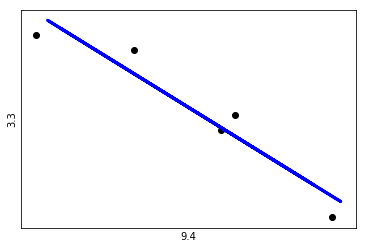

MAE: 0.27494
RMSE: 0.33088
R2: 0.887


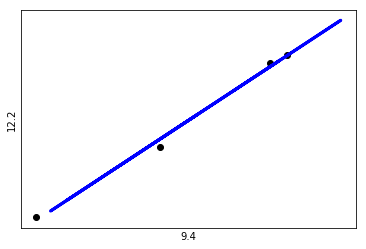

MAE: 0.05534
RMSE: 0.06047
R2: 0.994


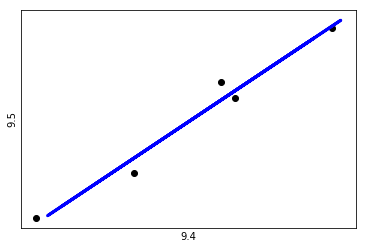

MAE: 1.46238
RMSE: 1.67861
R2: 0.968


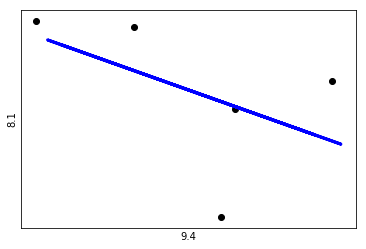

MAE: 1.80775
RMSE: 1.93463
R2: 0.000


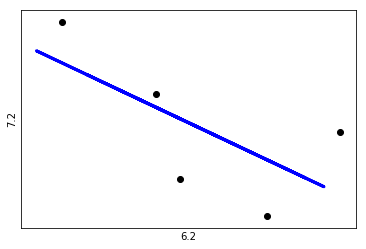

MAE: 0.26055
RMSE: 0.30603
R2: 0.508


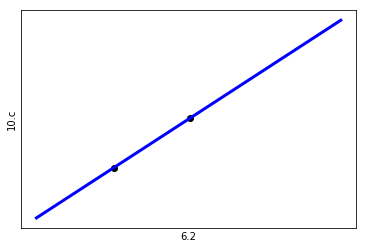

MAE: 0.26311
RMSE: 0.33243
R2: 0.764


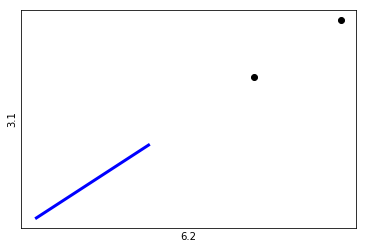

MAE: 4.16864
RMSE: 4.59326
R2: 0.000


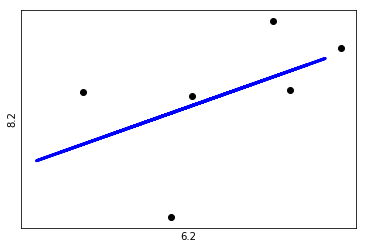

MAE: 1.48419
RMSE: 1.59799
R2: 0.000


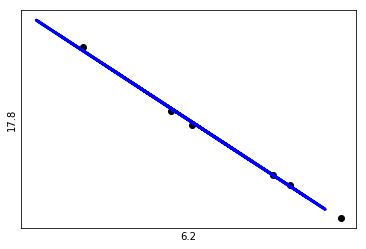

MAE: 0.83445
RMSE: 0.96901
R2: 0.993


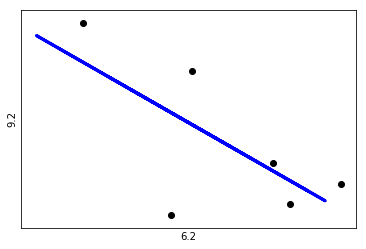

MAE: 0.23460
RMSE: 0.25866
R2: 0.674


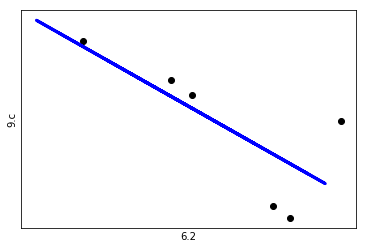

MAE: 4.92042
RMSE: 6.06782
R2: 0.837


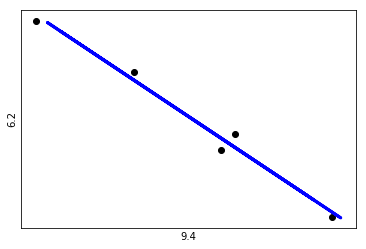

MAE: 0.53005
RMSE: 0.59807
R2: 0.954


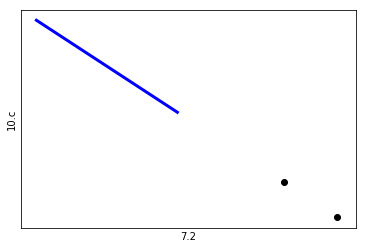

MAE: 0.97857
RMSE: 1.13681
R2: 0.000


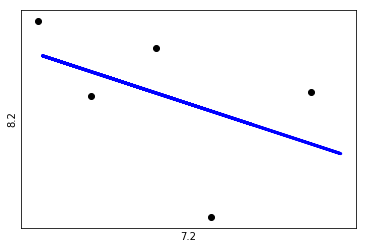

MAE: 0.97128
RMSE: 1.12470
R2: 0.000


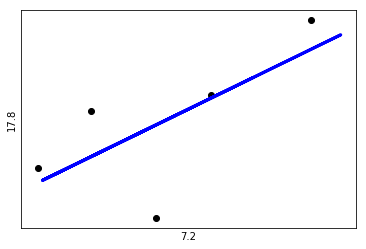

MAE: 6.61095
RMSE: 6.96716
R2: 0.569


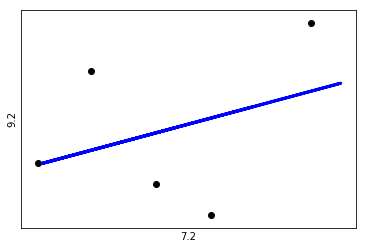

MAE: 0.39152
RMSE: 0.42209
R2: 0.126


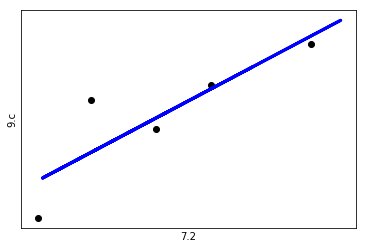

MAE: 10.75405
RMSE: 12.48221
R2: 0.343


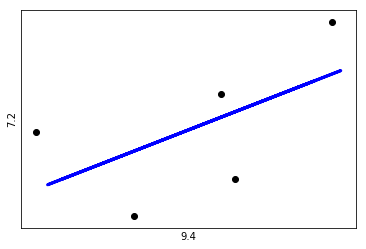

MAE: 0.30719
RMSE: 0.36411
R2: 0.303


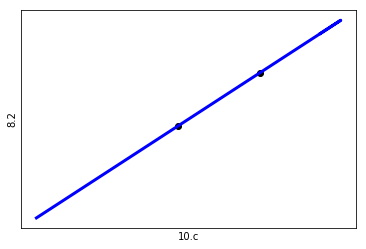

MAE: 0.29667
RMSE: 0.38086
R2: 0.189


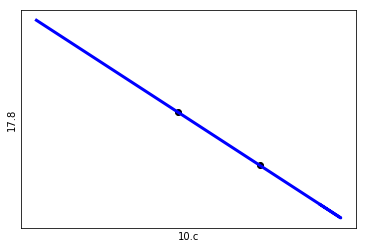

MAE: 2.15667
RMSE: 2.33263
R2: 0.792


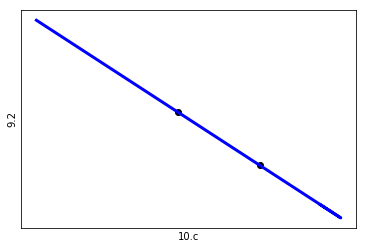

MAE: 0.01000
RMSE: 0.01000
R2: 0.982


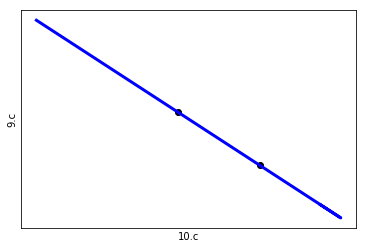

MAE: 1.88667
RMSE: 2.09411
R2: 0.000


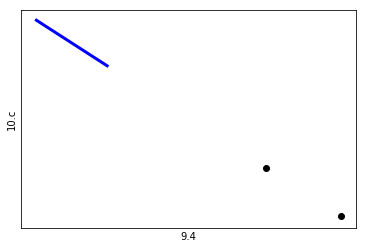

MAE: 0.69219
RMSE: 0.73247
R2: 0.000


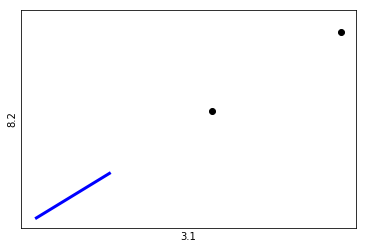

MAE: 1.17453
RMSE: 1.19090
R2: 0.015


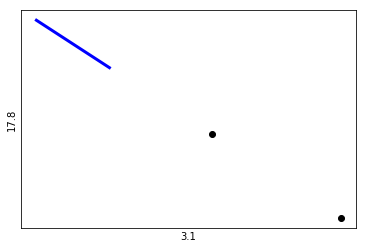

MAE: 10.77566
RMSE: 11.76255
R2: 0.000


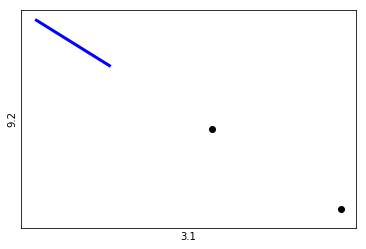

MAE: 0.54019
RMSE: 0.55192
R2: 0.000


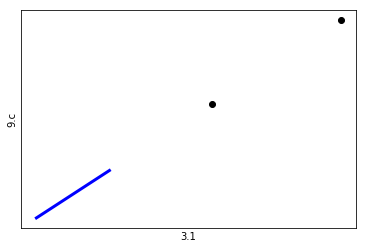

MAE: 44.07528
RMSE: 44.81698
R2: 0.000


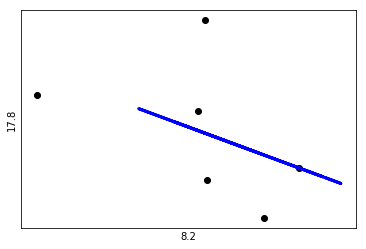

MAE: 12.96715
RMSE: 14.54703
R2: 0.000


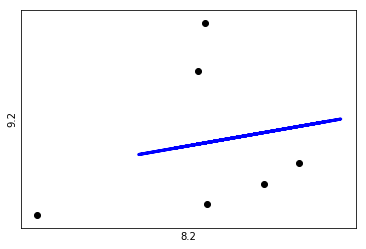

MAE: 0.48060
RMSE: 0.52719
R2: 0.000


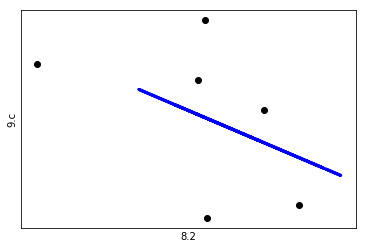

MAE: 17.66186
RMSE: 18.30851
R2: 0.000


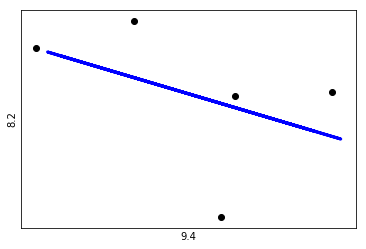

MAE: 1.44078
RMSE: 1.60056
R2: 0.000


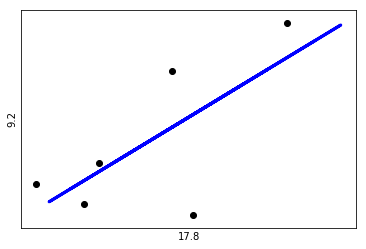

MAE: 0.22656
RMSE: 0.25498
R2: 0.683


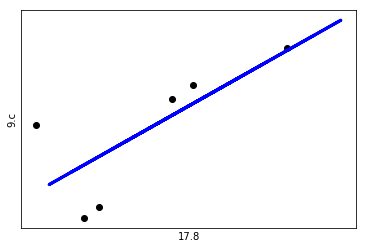

MAE: 5.23951
RMSE: 6.33433
R2: 0.822


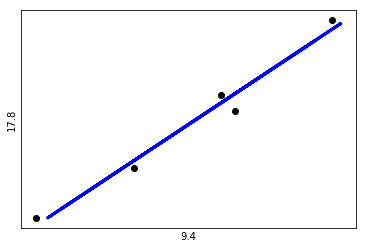

MAE: 2.39350
RMSE: 2.74641
R2: 0.933


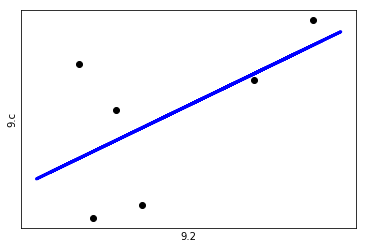

MAE: 5.23310
RMSE: 6.39355
R2: 0.819


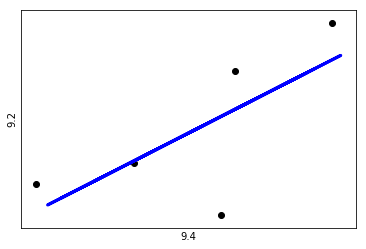

MAE: 0.19253
RMSE: 0.20369
R2: 0.796


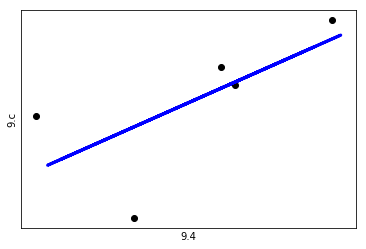

MAE: 6.96656
RMSE: 9.44412
R2: 0.624


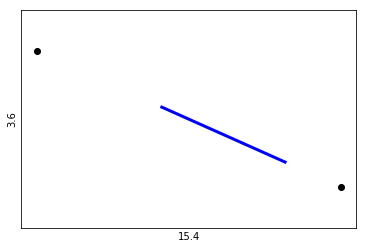

MAE: 0.07688
RMSE: 0.08176
R2: 0.000


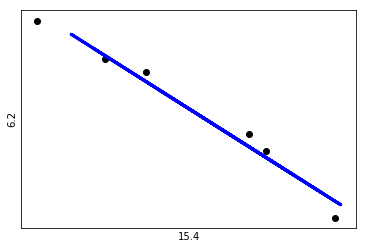

MAE: 0.53460
RMSE: 0.81906
R2: 0.929


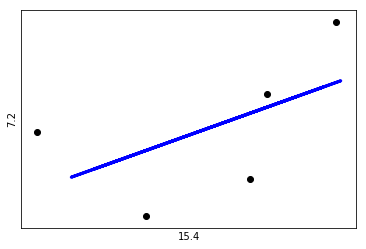

MAE: 0.28220
RMSE: 0.34624
R2: 0.370


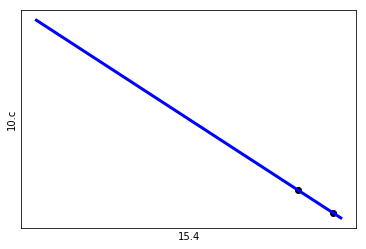

MAE: 1.28627
RMSE: 1.62405
R2: 0.000


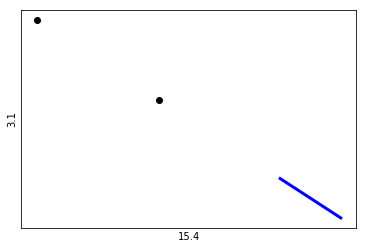

MAE: 0.83196
RMSE: 0.85361
R2: 0.676


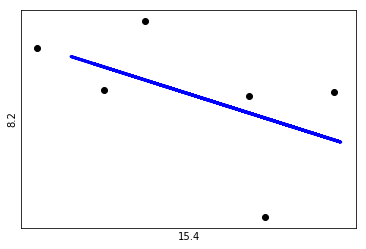

MAE: 1.41150
RMSE: 1.55641
R2: 0.000


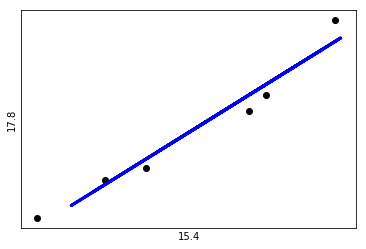

MAE: 2.71907
RMSE: 3.88565
R2: 0.892


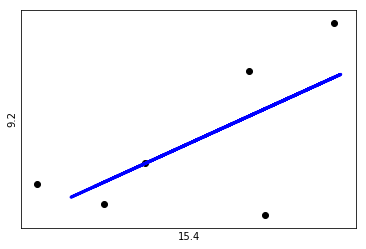

MAE: 0.28715
RMSE: 0.30805
R2: 0.548


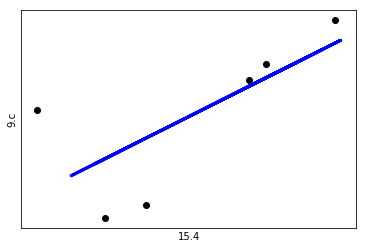

MAE: 5.31177
RMSE: 6.51998
R2: 0.812


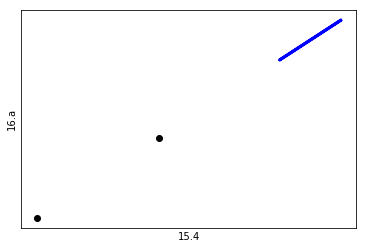

MAE: 8.34447
RMSE: 8.45079
R2: 0.000


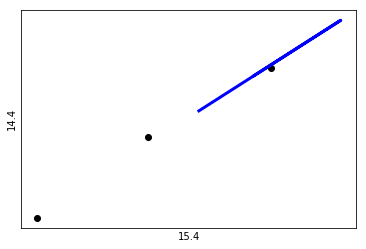

MAE: 2.99183
RMSE: 3.07189
R2: 0.396


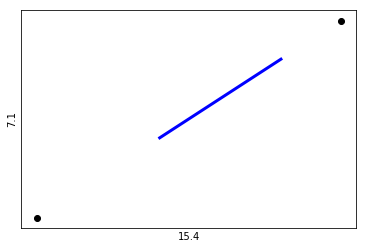

MAE: 0.98263
RMSE: 0.98604
R2: 0.770


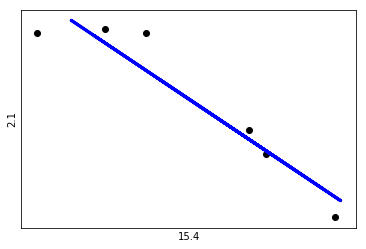

MAE: 0.47370
RMSE: 0.51963
R2: 0.897


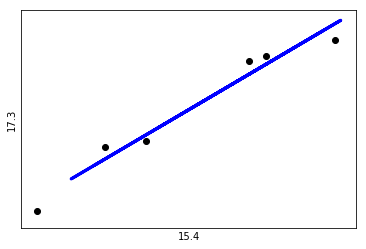

MAE: 0.01918
RMSE: 0.02155
R2: 0.958


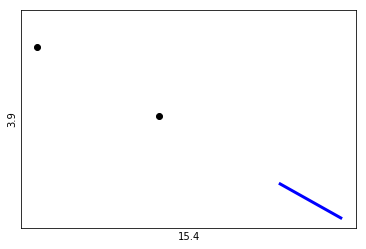

MAE: 0.01364
RMSE: 0.01380
R2: 0.000


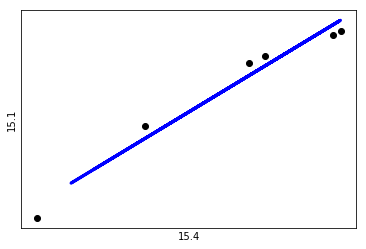

MAE: 0.64782
RMSE: 0.73522
R2: 0.959


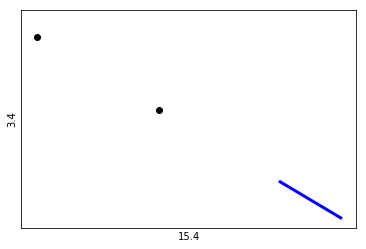

MAE: 0.01218
RMSE: 0.01572
R2: 0.605


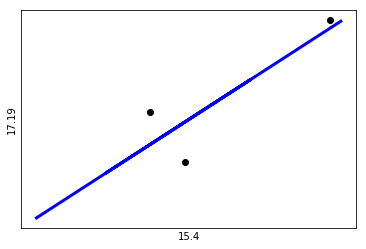

MAE: 137456203.68771
RMSE: 142487234.96960
R2: 0.000


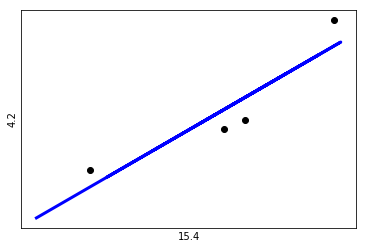

MAE: 1.35497
RMSE: 1.64465
R2: 0.753


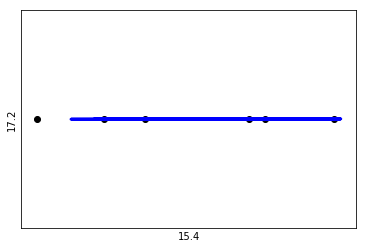

MAE: 0.00001
RMSE: 0.00001
R2: 0.759


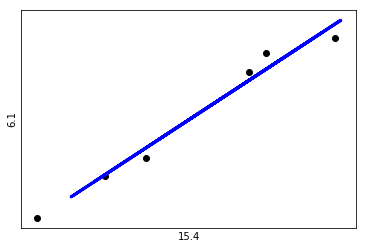

MAE: 1.06878
RMSE: 1.25749
R2: 0.942


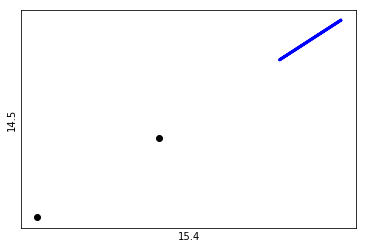

MAE: 6.26889
RMSE: 6.59792
R2: 0.000


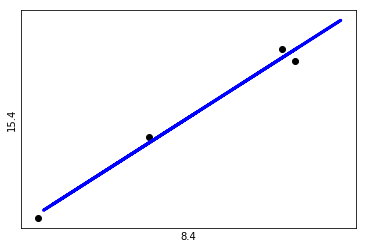

MAE: 0.87617
RMSE: 0.93370
R2: 0.849


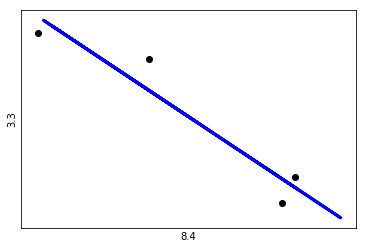

MAE: 0.24334
RMSE: 0.27356
R2: 0.775


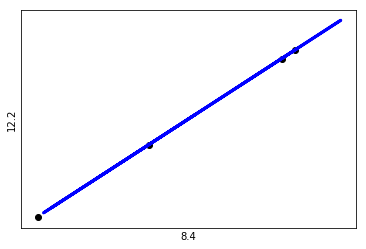

MAE: 0.00000
RMSE: 0.00000
R2: 1.000


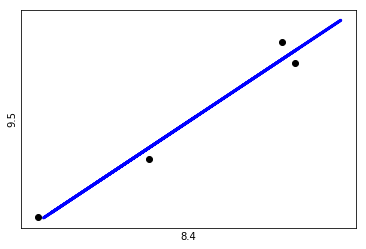

In [ ]:
keep =[]
processedPairs = list()
tonsTargets = ['12.2', '9.4', '8.4']   # work on this

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    
                    # TODO: modify, account for both tonnes, USD etc, find a different solution maybe considering percent
                    if ((targety in tonsTargets and not targetx in tonsTargets) or targety=='9.4'):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the testing set
                        y_pred = linreg.predict(X_valid)

                        plt.scatter(X_train, Y_train,  color='black')
                        plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                        plt.xticks(())
                        plt.yticks(())
                        plt.xlabel(targetx)
                        plt.ylabel(targety)
                        plt.show()
                        
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))

#print(keep)

In [67]:
y_pred[0]

array([ 44.8])

what needs to be done before

In [ ]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

In [ ]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

## Define STAN model

In [ ]:
SDG_STAN="""
data {
    int<lower = 0> N_obs;    // we might need such a variable for each observed variable because they could be different
    int<lower = 0> N_mis;    // how many do we want to infer
    int<lower = 1, upper = N_obs + N_mis> ix_obs1[N_obs];    // index for observed variable 1
    int<lower = 1, upper = N_obs + N_mis> ix_mis1[N_mis];
    int<lower = 1, upper = N_obs + N_mis> ix_obs2[N_obs];    // index for observed variable 2 -> more?
    int<lower = 1, upper = N_obs + N_mis> ix_mis2[N_mis];
    real y_obs1[N_obs];         // observed time-series data for variable 1
    real y_obs2[N_obs];         // observed time-series data for variable 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients
    corr_matrix[2] Omega;    // 2 because of two observed variables -> in our case 
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis];        // missing time-series data (to infer)
    real y_mis2[N_mis];        // missing time-series data (to infer)
}
model {
    for(i in 1:2)                   // 2 again because of two observed variables
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1  
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    for(t in 2:T) {
        vector[2] mu;
        mu[1] = beta[1]' * z[(t-1):(t-1),1];
        mu[2] = beta[2]' * z[(t-1):(t-1),2];
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood
    y2 ~ normal(z[:,2], sigma);    // likelihood
}
"""

In [ ]:
# prepare data for STAN model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

In [ ]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

In [ ]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
fit.plot(["tau","sigma","lp__"])
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
# insert def compute_error if deleted above
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))